University of California, Berkeley
Fall 2022, EECS 182/282

## The power of the graph perspective in clustering

#### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from scipy.linalg import svd
from scipy.spatial import distance
from sklearn.preprocessing import normalize

#### Helper Functions

In [2]:
def get_data(n_samples, seed):
    T_matrix = [[-0.60834549, -0.63667341], [0.40887718, 0.85253229]]
    X_orig, y_orig = make_blobs(n_samples=n_samples, random_state=170)
    X = np.dot(X_orig, T_matrix)
    return X

In [3]:
def show_data_results(X, num_plot=2, y_pred=None, cmap='jet'):
    if num_plot==1:
        plt.scatter(X[:, 0], X[:, 1])
        plt.title ("input data")
    elif num_plot==2:
        try:
            assert y_pred is not None
            fig = plt.figure(figsize=(10, 3))
            ax1 = fig.add_subplot(121)
            ax1.scatter(X[:, 0], X[:, 1])
            ax1.set(xticks=[],yticks=[],title ="input data")

            ax2 = fig.add_subplot(122)
            ax2.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap)
            ax2.set(xticks=[], yticks=[], title ="clustered data")
        except:
            print('y_pred is required for 2 plots')

## Q.1. (Given)

Please, read https://en.wikipedia.org/wiki/K-means_clustering about the Kmeans algorithm.

In this problem, we will show how interperting a dataset as a graph may result is obtaining an elegant clustering solution. We have an input dataset that we wish to cluster in 3 aparant classes. 

We provide the synthetic dataset of 2000 points described below where the T_matrix is just a 2D transformation matrix:

In [4]:
n_samples, seed = 2000, 170
X = get_data(n_samples, seed)

In [5]:
show_data_results(X, num_plot=1)

Using the the Kmeans algorithm implementation of sklearn, show your attempt to cluster this dataset into 3 classes in one luine of code.

## Solution (Given)

In [6]:
y_pred = KMeans(n_clusters=3, random_state=seed).fit_predict(X)

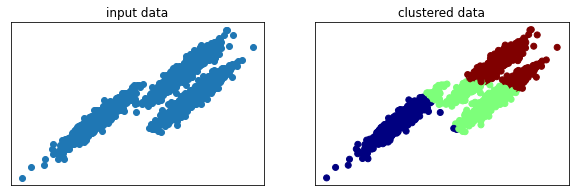

In [7]:
show_data_results(X, 2, y_pred)

## Q.2.

Comment on the output the the KMeans algorithm? Did it work? If so explain why, if not, explain not not.

## Solution

As could be seen above, it did not work. The Kmeans clustering algorithm minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances. 

if we try giving kmeans the correct means of each samples, it still will  still classify the points in a wrong way because as given, they have the wrong the embedding. In that sense each points votes for its cluster in an isolated way. 

Kmeans works using centroids which is the representation of the data center and each point are assigned to the nearest centroid.


## Q.3.

Let's now interprete every single point in the provided dataset as a node in a graph. Our goal is to find a way to relate every node in the graph is such way that they points that closer together maintain that relationship while points that are far are explicitely identified. 

lots of points points are closed top each other and kmaeans is missing it. representing as the graph unveils the relation.

One way to capture such relationship between points (nodes) in a graph is through the Adjacency matrix. Typically, a simple adjacency matrix between nodes of and indiredted graph is given by:

$$A_{i, j}=\begin{equation}
\left\{ 
  \begin{aligned}
    1: \text{if there is an edge between node i and node j}, \\
    0: \text{otherwise.}\\
  \end{aligned}
  \right.
\end{equation}
$$

In this probem, we will use the weighted distances betweeen points instead as a similary measure. Write a function that takes in the input dataset and some coeficient gamma which returns the adjacency matrix A.

$$A_{i, j} = e^{\gamma {||x_{i}-x_{j}||^2}}$$ 

where $x_{i}$ and $x_{j}$ represent each point in the provided dataset. You may find the $dictance$ module from $scipy.spatial$ useful.

In [8]:
def get_adjacency_matrix(gamma, X):
    # TODO: fill in your code here
    # adjacency_matrix = ?
    return adjacency_matrix

## Solution

In [14]:
def get_adjacency_matrix(gamma, X):
    return np.exp(- gamma * distance.cdist(X, X, metric='sqeuclidean'))

## Q. 4.

The degree matrix of an undirected graph is a diagonal matrix which contains information about the degree of each vertex. In other word, it contains the number of edges attached to each vertex and it is given by:

$$D_{i, j}=\begin{equation}
\left\{ 
  \begin{aligned}
    deg(v_{i}): \text{if i == j}, \\
    0: \text{otherwise.}\\
  \end{aligned}
  \right.
\end{equation}
$$

where the degree $ {\deg(v_{i})}$ of a vertex counts the number of times an edge terminates at that vertex. Note that in the traditional definition of the adjacency matrix, this boils down to the diagonal matrix in which element along the diagonals are column-wise sum of the adjacency matrix. Using the same idea, write a function that takes in the adjacency matrix as argument and returns the inverse square root of degree matrix.


In [9]:
def get_degree_matrix(adjacency_matrix):
    # TODO: fill in your code here
    # degree_matrix = ?
    return degree_matrix

## Solution

In [10]:
def get_degree_matrix(adjacency_matrix):
    degree_matrix = np.sum(adjacency_matrix, axis=1)
    return degree_matrix

## Q. 5.

Using $\gamma$ = 7.5, compute the symmetrically normalized adjacency matrix A, degree matrix D and the matrix $M = D^{-1/2} A D^{-1/2}$

In [ ]:
# adjacency_matrix = ?
# degree_matrix = ?
# M = ?

## Solution

In [15]:
gamma, num_clusters = 7.5, 3
adjacency_matrix = get_adjacency_matrix(gamma, X)


degree_matrix = get_degree_matrix(adjacency_matrix)

print((np.sqrt(1/degree_matrix)[np.newaxis, :]).shape)

M = np.multiply(np.sqrt(1/degree_matrix)[np.newaxis, :],
                np.multiply(adjacency_matrix,
                            np.sqrt(1/degree_matrix)[:, np.newaxis]))

(1, 2000)


In [16]:
np.multiply(adjacency_matrix,
                            np.sqrt(1/degree_matrix)[:, np.newaxis]).shape

(2000, 2000)

In [ ]:
print(M.shape)

(2000, 2000)


## Q. 6.

Using SVD decomposition, write a function that select the first 3 vectors in the matrix U and perform the same KMeans clustering used above to cluster them them. What do you observe? Did it work? If so explain why, if not, explain not not.

## Solution

In [20]:
def cluster_data(M):
    U = svd(M, full_matrices=False, lapack_driver='gesvd')[0]
    Usub = U[:, :num_clusters]
    print(Usub.shape)
    y_pred = KMeans(n_clusters=num_clusters, random_state=seed).fit_predict(Usub)
    return Usub, y_pred

y_pred_spectral = cluster_data(M)[1]
show_data_results(X, 2, y_pred_spectral)

(2000, 3)


NameError: ignored

## Q.7. 

Now lets think of the Adjacency obtained above as the transition Matrix in of a Markov Chain.To do so, A needs to be a proper stochastic matrix which means that the sum of the element in each column must add up to 1. Write a function that takes in the matrix M and returns M_stachastic, the stochastic version of M; compute the stochastic matrix

In [ ]:
def stochastic_matrix_converter(M):
    # TODO: fill in your code here
    # degree_matrix = ?
    return M_stoch

### Solution

In [ ]:
def stochastic_matrix_converter(M):
    M_stoch = M / np.sum(M, axis=0)[np.newaxis, :]
    return M_stoch

### Or 

In [ ]:
def stochastic_matrix_converter(M):
    M_stoch = np.zeros(M.shape)
    for i in range(M_stoch.shape[1]):
        M_stoch[:, i] = M[:, i]/sum(M[:, i])
    return M_stoch

In [ ]:
M_stoch = stochastic_matrix_converter(M)

perform the same KMeans clustering used above the resulting top 3 U vectors and plot your answers

In [ ]:
y_pred_spectral_stoch = cluster_data(M_stoch)[1]
show_data_results(X, 2, y_pred_spectral_stoch)

## Q.8.

Now, normalize those 3 vectors first before performing the clusturing. What do you observe? Did it work? If so explain why, if not, explain not not.

## Solution

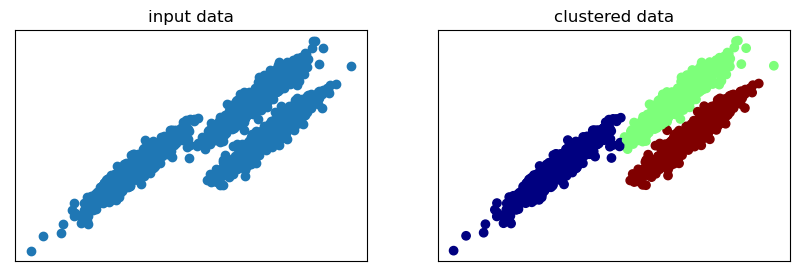

In [ ]:
Usub_norm = normalize(cluster_data(M)[0][:, :num_clusters])
y_pred_spectral_norm = KMeans(n_clusters=3, random_state=seed).fit_predict(Usub_norm)
show_data_results(X, 2, y_pred_spectral_norm)